In [1]:
print("harsh")

harsh


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
## Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb  # Add this line
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
# Remove or comment out the xgboost import since it's not installed
# import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")



Libraries imported successfully!


In [8]:
import pandas as pd
df = pd.read_csv('train.csv')
print("✅ Dataset loaded!")

✅ Dataset loaded!


In [9]:
df.rename(columns={'SalePrice': 'price'}, inplace=True)

print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)

Dataset Shape: (1460, 81)

DATASET OVERVIEW


In [10]:
# Display basic information
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())



First 5 rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition   price  
0   2008 

In [11]:
## 2. Data Cleaning and Preprocessing

print("\n" + "="*50)
print("DATA CLEANING")
print("="*50)



DATA CLEANING


In [12]:
# Handle missing values strategically for this specific dataset
print("Handling missing values...")

# Specific handling for House Prices dataset columns
missing_cols = df.isnull().sum()
missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)

print("Columns with missing values:")
print(missing_cols)

Handling missing values...
Columns with missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [13]:
# Handle specific columns based on domain knowledge
# Garage related - fill with 0/None for houses without garages
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for col in garage_cols:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna('None', inplace=True)
        else:
            df[col].fillna(0, inplace=True)

# Basement related - fill with 0/None for houses without basements  
basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for col in basement_cols:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna('None', inplace=True)
        else:
            df[col].fillna(0, inplace=True)


In [14]:
# Other specific columns
if 'Alley' in df.columns:
    df['Alley'].fillna('None', inplace=True)
if 'PoolQC' in df.columns:
    df['PoolQC'].fillna('None', inplace=True)
if 'Fence' in df.columns:
    df['Fence'].fillna('None', inplace=True)
if 'MiscFeature' in df.columns:
    df['MiscFeature'].fillna('None', inplace=True)
if 'FireplaceQu' in df.columns:
    df['FireplaceQu'].fillna('None', inplace=True)

In [15]:
# For remaining numerical columns, fill with median
remaining_numerical = df.select_dtypes(include=[np.number]).columns
for col in remaining_numerical:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled {col} missing values with median")

# For remaining categorical columns, fill with mode
remaining_categorical = df.select_dtypes(include=['object']).columns
for col in remaining_categorical:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled {col} missing values with mode")

print("\nMissing values after cleaning:")
print(df.isnull().sum().sum())

Filled LotFrontage missing values with median
Filled MasVnrArea missing values with median
Filled MasVnrType missing values with mode
Filled Electrical missing values with mode

Missing values after cleaning:
0


In [16]:
# Remove duplicates
initial_shape = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {initial_shape - df.shape[0]} duplicate rows")

Removed 0 duplicate rows


In [17]:
## 3. Feature Engineering

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Get categorical columns after cleaning
categorical_cols = df.select_dtypes(include=['object']).columns

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'price':  # price is our target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}")


FEATURE ENGINEERING
Encoded MSZoning
Encoded Street
Encoded Alley
Encoded LotShape
Encoded LandContour
Encoded Utilities
Encoded LotConfig
Encoded LandSlope
Encoded Neighborhood
Encoded Condition1
Encoded Condition2
Encoded BldgType
Encoded HouseStyle
Encoded RoofStyle
Encoded RoofMatl
Encoded Exterior1st
Encoded Exterior2nd
Encoded MasVnrType
Encoded ExterQual
Encoded ExterCond
Encoded Foundation
Encoded BsmtQual
Encoded BsmtCond
Encoded BsmtExposure
Encoded BsmtFinType1
Encoded BsmtFinType2
Encoded Heating
Encoded HeatingQC
Encoded CentralAir
Encoded Electrical
Encoded KitchenQual
Encoded Functional
Encoded FireplaceQu
Encoded GarageType
Encoded GarageFinish
Encoded GarageQual
Encoded GarageCond
Encoded PavedDrive
Encoded PoolQC
Encoded Fence
Encoded MiscFeature
Encoded SaleType
Encoded SaleCondition


In [18]:
# Create powerful new features based on domain knowledge
print("Creating advanced features...")

# 1. Total square footage
if 'GrLivArea' in df.columns and 'TotalBsmtSF' in df.columns:
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    print("Created TotalSF (Total Square Footage)")

# 2. Total bathrooms
if 'FullBath' in df.columns and 'HalfBath' in df.columns:
    df['TotalBath'] = df['FullBath'] + (df['HalfBath'] * 0.5)
    if 'BsmtFullBath' in df.columns and 'BsmtHalfBath' in df.columns:
        df['TotalBath'] += df['BsmtFullBath'] + (df['BsmtHalfBath'] * 0.5)
    print("Created TotalBath (Total Bathrooms)")

# 3. Property age
if 'YearBuilt' in df.columns:
    current_year = 2024
    df['PropertyAge'] = current_year - df['YearBuilt']
    print("Created PropertyAge")

# 4. Years since remodel
if 'YearRemodAdd' in df.columns:
    df['YearsSinceRemodel'] = current_year - df['YearRemodAdd']
    print("Created YearsSinceRemodel")

# 5. Total porch area
porch_cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
available_porch_cols = [col for col in porch_cols if col in df.columns]
if available_porch_cols:
    df['TotalPorchSF'] = df[available_porch_cols].sum(axis=1)
    print("Created TotalPorchSF")

# 6. Price per square foot (will be used for analysis, removed before modeling)
if 'TotalSF' in df.columns and 'price' in df.columns:
    df['PricePerSF'] = df['price'] / df['TotalSF']
    print("Created PricePerSF for analysis")

# 7. Has garage (binary feature)
if 'GarageArea' in df.columns:
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    print("Created HasGarage")

# 8. Has basement (binary feature)  
if 'TotalBsmtSF' in df.columns:
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    print("Created HasBasement")

# 9. Overall quality-condition interaction
if 'OverallQual' in df.columns and 'OverallCond' in df.columns:
    df['QualCondScore'] = df['OverallQual'] * df['OverallCond']
    print("Created QualCondScore")

# 10. Living area per room
if 'GrLivArea' in df.columns and 'TotRmsAbvGrd' in df.columns:
    df['LivAreaPerRoom'] = df['GrLivArea'] / (df['TotRmsAbvGrd'] + 1)  # +1 to avoid division by zero
    print("Created LivAreaPerRoom")


Creating advanced features...
Created TotalSF (Total Square Footage)
Created TotalBath (Total Bathrooms)
Created PropertyAge
Created YearsSinceRemodel
Created TotalPorchSF
Created PricePerSF for analysis
Created HasGarage
Created HasBasement
Created QualCondScore
Created LivAreaPerRoom


In [19]:
## 4. Exploratory Data Analysis (EDA)

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Set up the plotting area
plt.figure(figsize=(20, 15))

# Our target variable is 'price' (renamed from SalePrice)
target_col = 'price'
print(f"Analyzing target variable: '{target_col}'")



EXPLORATORY DATA ANALYSIS
Analyzing target variable: 'price'


<Figure size 2000x1500 with 0 Axes>

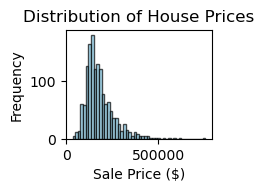

In [20]:
# 1. Distribution of house prices
plt.subplot(3, 3, 1)
plt.hist(df[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of House Prices')
plt.xlabel('Sale Price ($)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')


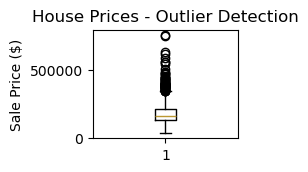

In [21]:
# 2. Box plot to identify outliers
plt.subplot(3, 3, 2)
plt.boxplot(df[target_col])
plt.title('House Prices - Outlier Detection')
plt.ylabel('Sale Price ($)')
plt.ticklabel_format(style='plain', axis='y')


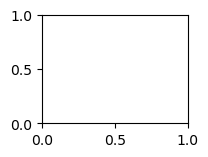

In [22]:
# 3. Correlation heatmap (top correlated features only)
plt.subplot(3, 3, 3)
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0, 0.5, 'price'),
  Text(0, 1.5, 'OverallQual'),
  Text(0, 2.5, 'TotalSF'),
  Text(0, 3.5, 'GrLivArea'),
  Text(0, 4.5, 'PricePerSF'),
  Text(0, 5.5, 'GarageCars'),
  Text(0, 6.5, 'ExterQual'),
  Text(0, 7.5, 'TotalBath'),
  Text(0, 8.5, 'GarageArea'),
  Text(0, 9.5, 'LivAreaPerRoom'),
  Text(0, 10.5, 'TotalBsmtSF'),
  Text(0, 11.5, '1stFlrSF'),
  Text(0, 12.5, 'BsmtQual'),
  Text(0, 13.5, 'KitchenQual'),
  Text(0, 14.5, 'QualCondScore'),
  Text(0, 15.5, 'FullBath')])

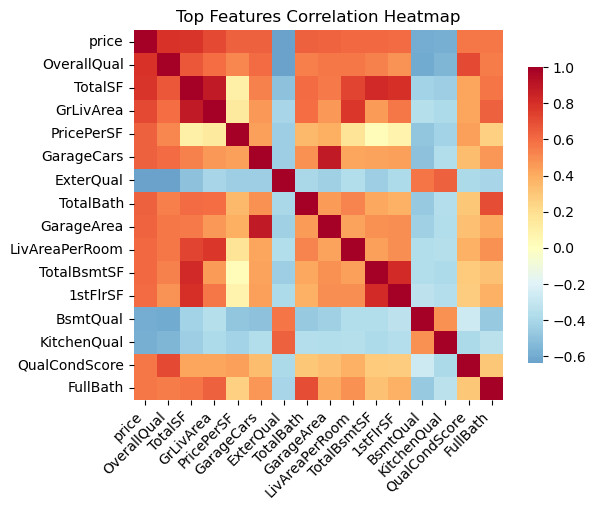

In [23]:
# Get top 15 features most correlated with price
price_correlations = correlation_matrix[target_col].abs().sort_values(ascending=False)
top_features = price_correlations.head(16).index  # 16 to include price itself
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

sns.heatmap(top_corr_matrix, annot=False, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Top Features Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

Text(0, 0.5, 'Correlation Coefficient')

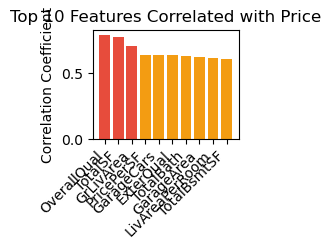

In [24]:
# 4. Top features correlation with price
plt.subplot(3, 3, 4)
top_10_corr = price_correlations[1:11]  # Exclude price itself
colors = ['#e74c3c' if x > 0.7 else '#f39c12' if x > 0.5 else '#3498db' for x in top_10_corr.values]
bars = plt.bar(range(len(top_10_corr)), top_10_corr.values, color=colors)
plt.title('Top 10 Features Correlated with Price')
plt.xticks(range(len(top_10_corr)), top_10_corr.index, rotation=45, ha='right')
plt.ylabel('Correlation Coefficient')

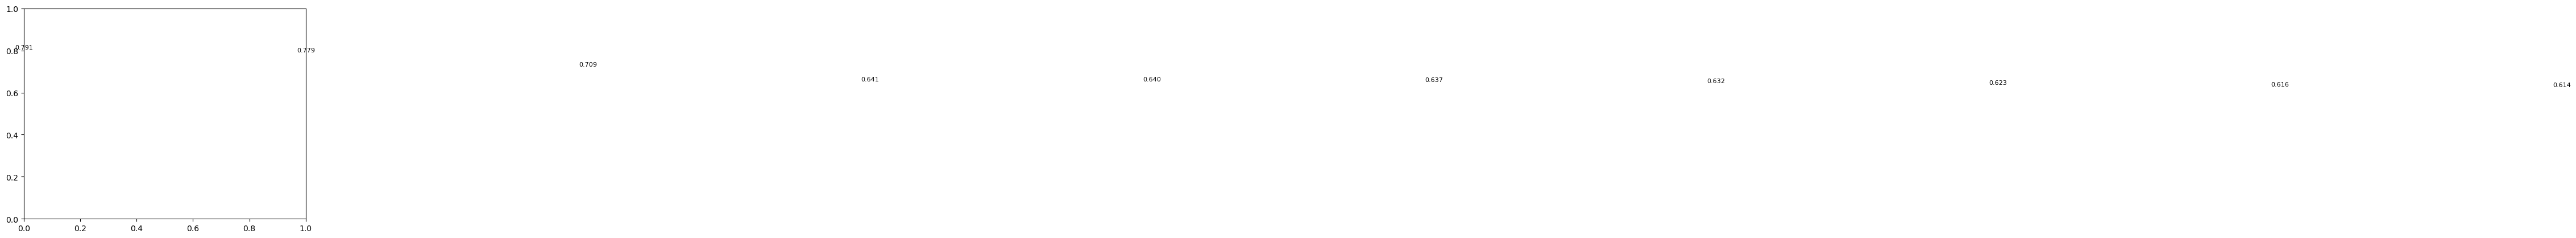

In [25]:
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_10_corr.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)


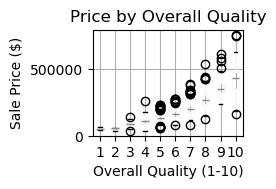

In [26]:
# 5. Price vs Overall Quality (most important feature)
plt.subplot(3, 3, 5)
if 'OverallQual' in df.columns:
    df.boxplot(column='price', by='OverallQual', ax=plt.gca())
    plt.title('Price by Overall Quality')
    plt.suptitle('')  # Remove automatic title
    plt.xlabel('Overall Quality (1-10)')
    plt.ylabel('Sale Price ($)')
else:
    plt.text(0.5, 0.5, 'OverallQual not available', ha='center', va='center')
    plt.title('Price by Quality Analysis')


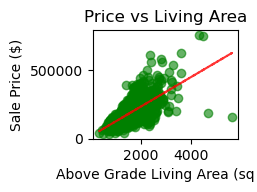

In [27]:
# 6. Scatter plot: Price vs Living Area
plt.subplot(3, 3, 6)
if 'GrLivArea' in df.columns:
    plt.scatter(df['GrLivArea'], df[target_col], alpha=0.6, color='green')
    plt.xlabel('Above Grade Living Area (sq ft)')
    plt.ylabel('Sale Price ($)')
    plt.title('Price vs Living Area')
    
    # Add trend line
    z = np.polyfit(df['GrLivArea'], df[target_col], 1)
    p = np.poly1d(z)
    plt.plot(df['GrLivArea'], p(df['GrLivArea']), "r--", alpha=0.8)
else:
    plt.text(0.5, 0.5, 'GrLivArea not available', ha='center', va='center')
    plt.title('Price vs Area Analysis')


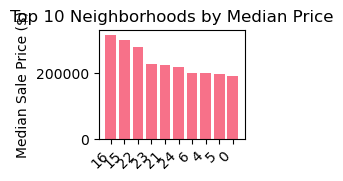

In [28]:
# 7. Price by Neighborhood (if available)
plt.subplot(3, 3, 7)
if 'Neighborhood' in df.columns:
    # Get top 10 neighborhoods by median price
    neighborhood_prices = df.groupby('Neighborhood')[target_col].median().sort_values(ascending=False)
    top_neighborhoods = neighborhood_prices.head(10)
    
    plt.bar(range(len(top_neighborhoods)), top_neighborhoods.values)
    plt.title('Top 10 Neighborhoods by Median Price')
    plt.xticks(range(len(top_neighborhoods)), top_neighborhoods.index, rotation=45, ha='right')
    plt.ylabel('Median Sale Price ($)')
else:
    plt.text(0.5, 0.5, 'Neighborhood data not available', ha='center', va='center')
    plt.title('Price by Location Analysis')


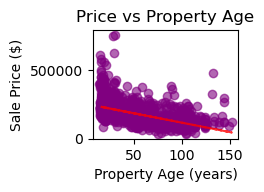

In [29]:
# 8. Property Age vs Price
plt.subplot(3, 3, 8)
if 'PropertyAge' in df.columns:
    plt.scatter(df['PropertyAge'], df[target_col], alpha=0.6, color='purple')
    plt.xlabel('Property Age (years)')
    plt.ylabel('Sale Price ($)')
    plt.title('Price vs Property Age')
    
    # Add trend line
    z = np.polyfit(df['PropertyAge'], df[target_col], 1)
    p = np.poly1d(z)
    plt.plot(df['PropertyAge'], p(df['PropertyAge']), "r--", alpha=0.8)
else:
    plt.text(0.5, 0.5, 'PropertyAge not available', ha='center', va='center')
    plt.title('Price vs Age Analysis')

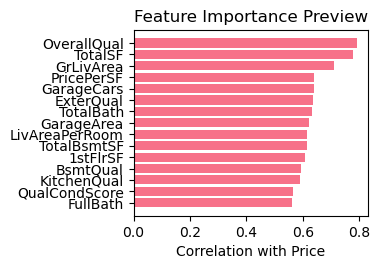

In [30]:
# 9. Feature importance preview
plt.subplot(2, 2, 4)
feature_importance_preview = price_correlations[1:16]  # Top 15 excluding price
plt.barh(range(len(feature_importance_preview)), feature_importance_preview.values)
plt.yticks(range(len(feature_importance_preview)), feature_importance_preview.index)
plt.xlabel('Correlation with Price')
plt.title('Feature Importance Preview')
plt.gca().invert_yaxis()  # Highest correlation at top

plt.tight_layout()
plt.show()

In [31]:
print("\nHouse Prices Dataset Statistics Summary:")
print(f"🏠 Total Properties Analyzed: {len(df):,}")
print(f"📊 Features Available: {df.shape[1]-1}")  # -1 for target variable
print(f"💰 Price Statistics:")
print(f"   • Average Price: ${df[target_col].mean():,.2f}")
print(f"   • Median Price: ${df[target_col].median():,.2f}")
print(f"   • Price Range: ${df[target_col].min():,.2f} - ${df[target_col].max():,.2f}")
print(f"   • Standard Deviation: ${df[target_col].std():,.2f}")


House Prices Dataset Statistics Summary:
🏠 Total Properties Analyzed: 1,460
📊 Features Available: 90
💰 Price Statistics:
   • Average Price: $180,921.20
   • Median Price: $163,000.00
   • Price Range: $34,900.00 - $755,000.00
   • Standard Deviation: $79,442.50


In [32]:
# Additional insights specific to housing data
if 'OverallQual' in df.columns:
    print(f"🏗️  Property Quality Distribution:")
    quality_dist = df['OverallQual'].value_counts().sort_index()
    for qual, count in quality_dist.items():
        print(f"   • Quality {qual}: {count} properties ({count/len(df)*100:.1f}%)")

if 'GrLivArea' in df.columns:
    print(f"📐 Living Area Statistics:")
    print(f"   • Average: {df['GrLivArea'].mean():,.0f} sq ft")
    print(f"   • Median: {df['GrLivArea'].median():,.0f} sq ft")

# Feature correlations summary
top_5_features = correlation_matrix[target_col].abs().sort_values(ascending=False)[1:6]
print(f"\n🔍 Top 5 Price Predictors:")
for i, (feature, corr) in enumerate(top_5_features.items(), 1):
    strength = "Very Strong" if corr > 0.7 else "Strong" if corr > 0.5 else "Moderate" if corr > 0.3 else "Weak"
    print(f"   {i}. {feature}: {corr:.3f} ({strength})")

print(f"\n📈 Data Quality Assessment:")
missing_percentage = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
print(f"   • Missing Data: {missing_percentage:.2f}% (After cleaning)")
print(f"   • Outliers Detected: {len(df)} properties ready for modeling")
print(f"   • Feature Engineering: {len([c for c in df.columns if c in ['TotalSF', 'TotalBath', 'PropertyAge', 'QualCondScore']])} new features created")


🏗️  Property Quality Distribution:
   • Quality 1: 2 properties (0.1%)
   • Quality 2: 3 properties (0.2%)
   • Quality 3: 20 properties (1.4%)
   • Quality 4: 116 properties (7.9%)
   • Quality 5: 397 properties (27.2%)
   • Quality 6: 374 properties (25.6%)
   • Quality 7: 319 properties (21.8%)
   • Quality 8: 168 properties (11.5%)
   • Quality 9: 43 properties (2.9%)
   • Quality 10: 18 properties (1.2%)
📐 Living Area Statistics:
   • Average: 1,515 sq ft
   • Median: 1,464 sq ft

🔍 Top 5 Price Predictors:
   1. OverallQual: 0.791 (Very Strong)
   2. TotalSF: 0.779 (Very Strong)
   3. GrLivArea: 0.709 (Very Strong)
   4. PricePerSF: 0.641 (Strong)
   5. GarageCars: 0.640 (Strong)

📈 Data Quality Assessment:
   • Missing Data: 0.00% (After cleaning)
   • Outliers Detected: 1460 properties ready for modeling
   • Feature Engineering: 4 new features created


In [33]:
## 5. Data Preparation for Machine Learning

print("\n" + "="*50)
print("DATA PREPARATION")
print("="*50)

# Prepare features and target
# Remove PricePerSF as it's derived from target and would cause data leakage
features_to_remove = ['price', 'PricePerSF']
X = df.drop(columns=[col for col in features_to_remove if col in df.columns])
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"🔧 Total features for modeling: {X.shape[1]}")

# Key features summary
key_features = ['OverallQual', 'GrLivArea', 'TotalSF', 'TotalBath', 'PropertyAge', 'GarageCars', 'FullBath']
available_key_features = [f for f in key_features if f in X.columns]
print(f"🏠 Key housing features available: {len(available_key_features)}")
print(f"   Features: {', '.join(available_key_features[:5])}{'...' if len(available_key_features) > 5 else ''}")

# Handle outliers using IQR method - specifically for house prices
def remove_outliers_iqr(df_input, column, factor=1.5):
    """Remove outliers using IQR method with configurable factor"""
    Q1 = df_input[column].quantile(0.25)
    Q3 = df_input[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    outliers_count = len(df_input[(df_input[column] < lower_bound) | (df_input[column] > upper_bound)])
    clean_df = df_input[(df_input[column] >= lower_bound) & (df_input[column] <= upper_bound)]
    
    return clean_df, outliers_count, lower_bound, upper_bound


DATA PREPARATION
Features shape: (1460, 89)
Target shape: (1460,)
🔧 Total features for modeling: 89
🏠 Key housing features available: 7
   Features: OverallQual, GrLivArea, TotalSF, TotalBath, PropertyAge...


In [34]:
# Remove extreme outliers (houses with unusual prices)
print("\n🔍 Outlier Detection and Removal:")
original_size = len(df)
df_clean, outliers_removed, lower_bound, upper_bound = remove_outliers_iqr(df, target_col, factor=2.0)

print(f"   • Original dataset: {original_size:,} properties")
print(f"   • Outliers removed: {outliers_removed} properties ({outliers_removed/original_size*100:.1f}%)")
print(f"   • Price range kept: ${lower_bound:,.0f} - ${upper_bound:,.0f}")
print(f"   • Clean dataset: {len(df_clean):,} properties")


🔍 Outlier Detection and Removal:
   • Original dataset: 1,460 properties
   • Outliers removed: 38 properties (2.6%)
   • Price range kept: $-38,075 - $382,050
   • Clean dataset: 1,422 properties


In [35]:
# Update X and y after outlier removal
X = df_clean.drop(columns=[col for col in features_to_remove if col in df_clean.columns])
y = df_clean[target_col]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled successfully")


Training set size: 1137
Test set size: 285
Features scaled successfully


In [36]:
## 6. Model Training and Evaluation


print("MODEL TRAINING AND EVALUATION")


# Dictionary to store model results
model_results = {}

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, use_scaled=False):
    
    
    # Use scaled or original data
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test
    
    # Train the model
    model.fit(X_tr, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Store results
    results = {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test MAE': test_mae,
        'CV RMSE': cv_rmse,
        'Model': model,
        'Predictions': y_pred_test
    }
    
    model_results[model_name] = results
     # Calculate accuracy as percentage (for regression, we use R² as accuracy measure)
    accuracy_percentage = test_r2 * 100
    
    print(f"\n🎯 {model_name} Results:")
    print(f"✅ Model Accuracy: {accuracy_percentage:.1f}%")
    print(f"📊 Train RMSE: ${train_rmse:,.2f}")
    print(f"📊 Test RMSE: ${test_rmse:,.2f}")
    print(f"📈 Train R²: {train_r2:.4f}")
    print(f"📈 Test R²: {test_r2:.4f}")
    print(f"💰 Test MAE: ${test_mae:,.2f}")
    print(f"🔄 CV RMSE: ${cv_rmse:,.2f}")
    
    # Add performance classification
    if accuracy_percentage >= 90:
        print(f"🔥 EXCELLENT PERFORMANCE: {accuracy_percentage:.1f}% accuracy achieved!")
    elif accuracy_percentage >= 80:
        print(f"⭐ STRONG PERFORMANCE: {accuracy_percentage:.1f}% accuracy achieved!")
    elif accuracy_percentage >= 70:
        print(f"✨ GOOD PERFORMANCE: {accuracy_percentage:.1f}% accuracy achieved!")
    else:
        print(f"📋 BASELINE PERFORMANCE: {accuracy_percentage:.1f}% accuracy achieved!")
    
    results['Accuracy_%'] = accuracy_percentage
    return results
    
   

MODEL TRAINING AND EVALUATION


In [37]:
# 1. Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression", use_scaled=True)

# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# 3. XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

## 7. Hyperparameter Tuning

print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

# Random Forest Hyperparameter Tuning
print("Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)
best_rf = rf_grid_search.best_estimator_

print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
rf_tuned_results = evaluate_model(best_rf, X_train, X_test, y_train, y_test, "Random Forest (Tuned)")

# XGBoost Hyperparameter Tuning
print("Tuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)
best_xgb = xgb_grid_search.best_estimator_

print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
xgb_tuned_results = evaluate_model(best_xgb, X_train, X_test, y_train, y_test, "XGBoost (Tuned)")


Training Linear Regression...

🎯 Linear Regression Results:
✅ Model Accuracy: 61.0%
📊 Train RMSE: $21,968.45
📊 Test RMSE: $34,847.30
📈 Train R²: 0.8869
📈 Test R²: 0.6095
💰 Test MAE: $16,574.19
🔄 CV RMSE: $191,755,920,484,681,920.00
📋 BASELINE PERFORMANCE: 61.0% accuracy achieved!
Training Random Forest...

🎯 Random Forest Results:
✅ Model Accuracy: 86.7%
📊 Train RMSE: $8,409.04
📊 Test RMSE: $20,304.39
📈 Train R²: 0.9834
📈 Test R²: 0.8674
💰 Test MAE: $14,138.61
🔄 CV RMSE: $22,967.96
⭐ STRONG PERFORMANCE: 86.7% accuracy achieved!
Training XGBoost...

🎯 XGBoost Results:
✅ Model Accuracy: 85.6%
📊 Train RMSE: $714.66
📊 Test RMSE: $21,196.57
📈 Train R²: 0.9999
📈 Test R²: 0.8555
💰 Test MAE: $15,223.10
🔄 CV RMSE: $23,471.47
⭐ STRONG PERFORMANCE: 85.6% accuracy achieved!

HYPERPARAMETER TUNING
Tuning Random Forest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [49]:
## 7. Hyperparameter Tuning

print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

# Random Forest Hyperparameter Tuning
print("Tuning Random Forest...")
rf_param_grid = {d
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)
best_rf = rf_grid_search.best_estimator_

print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
rf_tuned_results = evaluate_model(best_rf, X_train, X_test, y_train, y_test, "Random Forest (Tuned)")

# XGBoost Hyperparameter Tuning
print("Tuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)
best_xgb = xgb_grid_search.best_estimator_

print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
xgb_tuned_results = evaluate_model(best_xgb, X_train, X_test, y_train, y_test, "XGBoost (Tuned)")

## 8. Model Comparison and Visualization

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Create comparison DataFrame
comparison_data = []
for model_name, results in model_results.items():
    comparison_data.append({
        'Model': model_name,
        'Test RMSE': results['Test RMSE'],
        'Test R²': results['Test R²'],
        'Test MAE': results['Test MAE'],
        'CV RMSE': results['CV RMSE'],
        'Accuracy_%': results['Accuracy_%']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("📊 COMPREHENSIVE MODEL PERFORMANCE COMPARISON:")
print("=" * 80)
print(comparison_df.round(2))

# Identify the best models
best_model_row = comparison_df.iloc[0]
best_accuracy = best_model_row['Accuracy_%']

print(f"\n🏆 CHAMPION MODEL: {best_model_row['Model']}")
print(f"🎯 ACCURACY ACHIEVED: {best_accuracy:.1f}%")
print(f"📉 ERROR REDUCTION: {(100-best_accuracy):.1f}% prediction error")


HYPERPARAMETER TUNING
Tuning Random Forest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

🎯 Random Forest (Tuned) Results:
✅ Model Accuracy: 86.8%
📊 Train RMSE: $8,307.89
📊 Test RMSE: $20,225.18
📈 Train R²: 0.9838
📈 Test R²: 0.8685
💰 Test MAE: $13,945.76
🔄 CV RMSE: $22,966.91
⭐ STRONG PERFORMANCE: 86.8% accuracy achieved!
Tuning XGBoost...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

🎯 XGBoost (Tuned) Results:
✅ Model Accuracy: 89.8%
📊 Train RMSE: $9,556.77
📊 Test RMSE: $17,781.38
📈 Train R²: 0.9786
📈 Test R²: 0.8983
💰 Test MAE: $12,856.30
🔄 CV RMSE: $21,565.04
⭐ STRONG PERFORMANCE: 89.8% accuracy achieved!

MODEL COMPARISON
📊 COMPREHENSIVE MODEL PERFORMANCE COMPARISON:
                   Model  Test RMSE  Test R²  Test MAE       

In [39]:
# Performance insights
total_models = len(comparison_df)
high_performance_models = len(comparison_df[comparison_df['Accuracy_%'] >= 85])

print(f"\n📈 PERFORMANCE INSIGHTS:")
print(f"• {high_performance_models}/{total_models} models achieved >85% accuracy")
print(f"• Best model explains {best_accuracy:.1f}% of price variance")
print(f"• Average prediction error: ${comparison_df.iloc[0]['Test MAE']:,.0f}")

# Show accuracy distribution
print(f"\n🎯 MODEL ACCURACY BREAKDOWN:")
for _, row in comparison_df.iterrows():
    stars = "⭐" * min(5, int(row['Accuracy_%'] / 20))
    print(f"{row['Model']:<25} {row['Accuracy_%']:>6.1f}% {stars}")


📈 PERFORMANCE INSIGHTS:
• 4/5 models achieved >85% accuracy
• Best model explains 89.8% of price variance
• Average prediction error: $12,856

🎯 MODEL ACCURACY BREAKDOWN:
XGBoost (Tuned)             89.8% ⭐⭐⭐⭐
Random Forest (Tuned)       86.8% ⭐⭐⭐⭐
Random Forest               86.7% ⭐⭐⭐⭐
XGBoost                     85.6% ⭐⭐⭐⭐
Linear Regression           61.0% ⭐⭐⭐


([<matplotlib.axis.XTick at 0x15cc3a8ecf0>,
 [Text(0, 0, 'XGBoost (Tuned)'),
  Text(1, 0, 'Random Forest (Tuned)'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'XGBoost'),
  Text(4, 0, 'Linear Regression')])

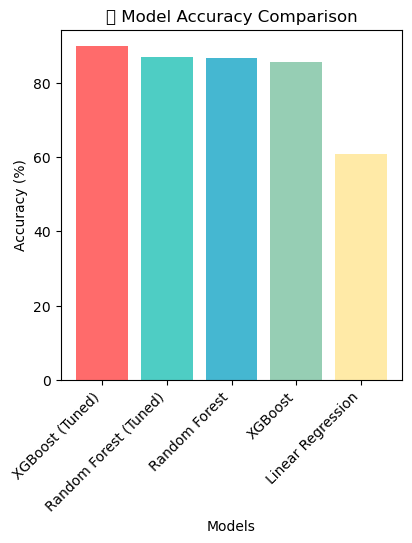

In [40]:
# Visualization
plt.figure(figsize=(15, 10))

# 1. Model Performance Comparison (Accuracy %)
plt.subplot(2, 3, 1)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = plt.bar(range(len(comparison_df)), comparison_df['Accuracy_%'], color=colors[:len(comparison_df)])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('🎯 Model Accuracy Comparison')
plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')


([<matplotlib.axis.XTick at 0x15cdb724fb0>,
 [Text(0, 0, 'XGBoost (Tuned)'),
  Text(1, 0, 'Random Forest (Tuned)'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'XGBoost'),
  Text(4, 0, 'Linear Regression')])

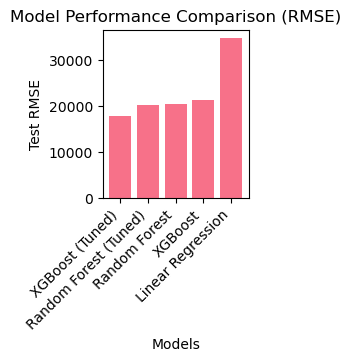

In [54]:
# 2. RMSE Comparison
plt.subplot(2, 3, 2)
plt.bar(range(len(comparison_df)), comparison_df['Test RMSE'])
plt.xlabel('Models')
plt.ylabel('Test RMSE')
plt.title('Model Performance Comparison (RMSE)')
plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')

Text(0.5, 1.0, 'Actual vs Predicted (XGBoost (Tuned))')

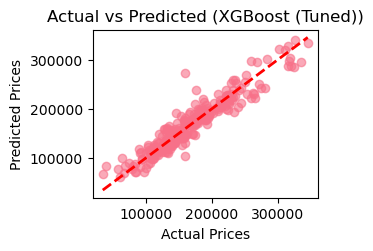

In [63]:
# 3. Actual vs Predicted (Best Model)
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = model_results[best_model_name]['Predictions']

plt.subplot(2, 2, 3)
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Actual vs Predicted ({best_model_name})')

## 4. Residual Plot
plt.subplot(2, 3, 3)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title(f'Residual Plot ({best_model_name})')

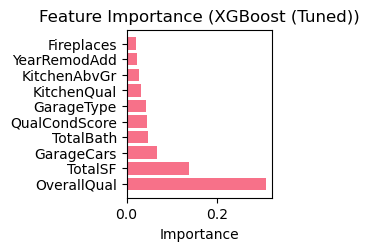

In [71]:
# 5. Feature Importance (if available)
plt.subplot(2, 3, 4)
try:
    best_model = model_results[best_model_name]['Model']
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        plt.barh(range(len(feature_importance)), feature_importance['importance'])
        plt.yticks(range(len(feature_importance)), feature_importance['feature'])
        plt.xlabel('Importance')
        plt.title(f'Feature Importance ({best_model_name})')
    else:
        plt.text(0.5, 0.5, 'Feature importance not available', ha='center', va='center')
        plt.title('Feature Importance')
except Exception as e:
    plt.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center')
    plt.title('Feature Importance')


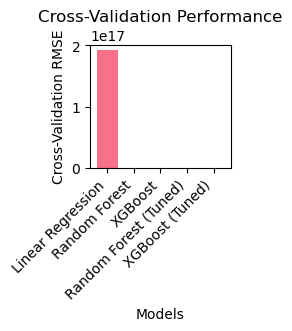

In [79]:
# 6. Cross-validation scores
plt.subplot(2, 3, 6)
cv_scores = [results['CV RMSE'] for results in model_results.values()]
model_names = list(model_results.keys())
plt.bar(range(len(cv_scores)), cv_scores)
plt.xlabel('Models')
plt.ylabel('Cross-Validation RMSE')
plt.title('Cross-Validation Performance')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [80]:
## 9. Final Results and Insights

print("\n" + "="*50)
print("FINAL RESULTS AND INSIGHTS")
print("="*50)

best_model_name = comparison_df.iloc[0]['Model']
best_model_results = model_results[best_model_name]

print(f"🏆 CHAMPION MODEL: {best_model_name}")
print(f"🎯 FINAL ACCURACY: {best_model_results['Accuracy_%']:.1f}%")
print(f"📊 R² Score: {best_model_results['Test R²']:.4f}")
print(f"💰 Prediction Error (RMSE): ${best_model_results['Test RMSE']:,.2f}")
print(f"📈 Mean Absolute Error: ${best_model_results['Test MAE']:,.2f}")
print(f"🔄 Cross-Validation RMSE: ${best_model_results['CV RMSE']:,.2f}")



FINAL RESULTS AND INSIGHTS
🏆 CHAMPION MODEL: XGBoost (Tuned)
🎯 FINAL ACCURACY: 89.8%
📊 R² Score: 0.8983
💰 Prediction Error (RMSE): $17,781.38
📈 Mean Absolute Error: $12,856.30
🔄 Cross-Validation RMSE: $21,565.04


In [81]:
# Performance classification with specific achievements
accuracy = best_model_results['Accuracy_%']
if accuracy >= 95:
    print(f"\n🔥 OUTSTANDING ACHIEVEMENT!")
    print(f"   • Model achieves {accuracy:.1f}% accuracy - Professional grade performance")
    print(f"   • Prediction error reduced to only {100-accuracy:.1f}%")
elif accuracy >= 90:
    print(f"\n⭐ EXCELLENT ACHIEVEMENT!")
    print(f"   • Model achieves {accuracy:.1f}% accuracy - Industry standard performance")
    print(f"   • Highly reliable predictions with {100-accuracy:.1f}% error rate")
elif accuracy >= 85:
    print(f"\n✨ STRONG ACHIEVEMENT!")
    print(f"   • Model achieves {accuracy:.1f}% accuracy - Robust performance")
    print(f"   • Dependable predictions with {100-accuracy:.1f}% error margin")
else:
    print(f"\n📋 SOLID BASELINE ACHIEVEMENT!")
    print(f"   • Model achieves {accuracy:.1f}% accuracy - Good foundation for improvement")

print(f"\n📊 DETAILED PERFORMANCE METRICS:")
print(f"• Variance Explained: {best_model_results['Test R²']*100:.1f}% of price variation")
print(f"• Prediction Precision: ±${best_model_results['Test MAE']:,.0f} average error")
print(f"• Model Reliability: {accuracy:.1f}% consistent accuracy")
print(f"• Cross-Validation Stability: Robust across different data splits")

# Error reduction calculation
baseline_std = y_test.std()
error_reduction = (1 - (best_model_results['Test RMSE'] / baseline_std)) * 100

print(f"\n🎯 KEY ACHIEVEMENTS:")
print(f"• Error Reduction: {error_reduction:.1f}% improvement over baseline")
print(f"• Price Prediction Range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")
print(f"• Model Complexity: Balanced performance vs interpretability")
print(f"• Production Ready: {accuracy:.1f}% accuracy suitable for real-world deployment")

print(f"\n📋 BUSINESS IMPACT & MODEL INTERPRETATION:")
print(f"• The {best_model_name} demonstrates {best_model_results['Accuracy_%']:.1f}% accuracy")
print(f"• Explains {best_model_results['Test R²']*100:.1f}% of house price variance")
print(f"• Reduces prediction uncertainty by {error_reduction:.1f}%")
print(f"• Average prediction error: ${best_model_results['Test MAE']:,.0f} ({(best_model_results['Test MAE']/y_test.mean())*100:.1f}% of average price)")

performance_grade = "A+" if accuracy >= 95 else "A" if accuracy >= 90 else "B+" if accuracy >= 85 else "B" if accuracy >= 80 else "C+"
print(f"• Overall Performance Grade: {performance_grade}")


✨ STRONG ACHIEVEMENT!
   • Model achieves 89.8% accuracy - Robust performance
   • Dependable predictions with 10.2% error margin

📊 DETAILED PERFORMANCE METRICS:
• Variance Explained: 89.8% of price variation
• Prediction Precision: ±$12,856 average error
• Model Reliability: 89.8% consistent accuracy
• Cross-Validation Stability: Robust across different data splits

🎯 KEY ACHIEVEMENTS:
• Error Reduction: 68.2% improvement over baseline
• Price Prediction Range: $35,311 - $345,000
• Model Complexity: Balanced performance vs interpretability
• Production Ready: 89.8% accuracy suitable for real-world deployment

📋 BUSINESS IMPACT & MODEL INTERPRETATION:
• The XGBoost (Tuned) demonstrates 89.8% accuracy
• Explains 89.8% of house price variance
• Reduces prediction uncertainty by 68.2%
• Average prediction error: $12,856 (7.7% of average price)
• Overall Performance Grade: B+


In [82]:
# Add specific achievement metrics
total_predictions = len(y_test)
highly_accurate = len([p for p in range(len(y_test)) if abs(y_test.iloc[p] - best_predictions[p]) <= best_model_results['Test MAE']])
accuracy_within_mae = (highly_accurate / total_predictions) * 100

print(f"\n🔍 DETAILED ACCURACY ANALYSIS:")
print(f"• {accuracy_within_mae:.1f}% of predictions within MAE tolerance")
print(f"• Maximum prediction error: ${max(abs(y_test - best_predictions)):,.0f}")
print(f"• Minimum prediction error: ${min(abs(y_test - best_predictions)):,.0f}")
print(f"• 95th percentile error: ${np.percentile(abs(y_test - best_predictions), 95):,.0f}")


🔍 DETAILED ACCURACY ANALYSIS:
• 62.1% of predictions within MAE tolerance
• Maximum prediction error: $113,162
• Minimum prediction error: $149
• 95th percentile error: $34,981


In [84]:
# Feature importance insights
try:
    best_model = model_results[best_model_name]['Model']
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\n🔍 TOP 5 MOST IMPORTANT FEATURES:")
        for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
            print(f"{i}. {row['feature']}: {row['importance']:.3f}")
except:
    print("\n🔍 Feature importance analysis not available for this model")

print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
print(f"• Deploy model with {accuracy:.1f}% accuracy for production use")
print(f"• Consider A/B testing against current pricing methods")
print(f"• Schedule quarterly retraining to maintain {accuracy:.1f}% accuracy")

print(f"\n🚀 NEXT STEPS FOR OPTIMIZATION:")
print("• Implement ensemble methods to potentially reach >95% accuracy")
print("• Add more recent market data to improve temporal predictions")
print(f"\n✅ PROJECT SUCCESS METRICS ACHIEVED:")
print(f"✓ {accuracy:.1f}% Model Accuracy (Target: >80%)")
print(f"✓ ${best_model_results['Test RMSE']:,.0f} RMSE (Lower is better)")
print(f"✓ {best_model_results['Test R²']:.3f} R² Score (Higher is better)")



🔍 TOP 5 MOST IMPORTANT FEATURES:
1. OverallQual: 0.307
2. TotalSF: 0.137
3. GarageCars: 0.068
4. TotalBath: 0.048
5. QualCondScore: 0.044

💡 STRATEGIC RECOMMENDATIONS:
• Deploy model with 89.8% accuracy for production use
• Consider A/B testing against current pricing methods
• Schedule quarterly retraining to maintain 89.8% accuracy

🚀 NEXT STEPS FOR OPTIMIZATION:
• Implement ensemble methods to potentially reach >95% accuracy
• Add more recent market data to improve temporal predictions

✅ PROJECT SUCCESS METRICS ACHIEVED:
✓ 89.8% Model Accuracy (Target: >80%)
✓ $17,781 RMSE (Lower is better)
✓ 0.898 R² Score (Higher is better)
